In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

# Chapter 4 - Classification

* [4.1 An Overview of Classification](#4.1-An-Overview-of-Classification)
* [4.3 Logistic Regression](#4.3-Logistic-Regression)
    * [4.3.1 The Logistic Model](#4.3.1-The-Logistic-Model)
    * [4.3.2 Estimating the Regression Coefficients](#4.3.2-Estimating-the-Regression-Coefficients)
- [4.4 Linear Discriminant Analysis](#4.4-Linear-Discriminant-Analysis)
- [Lab: 4.6.3 Linear Discriminant Analysis](#4.6.3-Linear-Discriminant-Analysis)
- [Lab: 4.6.4 Quadratic Discriminant Analysis](#4.6.4-Quadratic-Discriminant-Analysis)
- [Lab: 4.6.5 K-Nearest Neighbors](#4.6.5-K-Nearest-Neighbors)
- [Lab: 4.6.6 An Application to Caravan Insurance Data](#4.6.6-An-Application-to-Caravan-Insurance-Data)

## 4.1 An Overview of Classification

We are interested in predicting whether an individual will default on his or her credit card payment, on the basis of annual income and monthly credit card balance. The data set is displayed in [Figure 4.1](#Figure-4.1). We have plotted annual income and monthly credit card balance for a subset of 10,000 individuals.

The left-hand panel of [Figure 4.1](#Figure-4.1) displays individuals who defaulted in a given month in orange, and those who did not in blue. (The overall default rate is about 3%, so we have plotted only a fraction of the individuals who did not default.) It appears that individuals who defaulted tended to have higher credit card balances than those who did not. In the right-hand panel of [Figure 4.1](#Figure-4.1), two pairs of boxplots are shown. The first shows the distribution of balance split by the binary default variable; the second is a similar plot for income . In this chapter, we learn how to build a model to predict default $(Y )$ for any given value of balance $(X_1 )$ and income $(X_2 )$. Since $Y$ is ***not quantitative***, the simple linear regression model of Chapter 3 is not appropriate.

In [12]:
df = pd.read_excel('Data/Default.xlsx')
# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(5)

,Unnamed: 0,default,student,balance,income,default2,student2
0,1,No,No,729.526495,44361.625074,0,0
1,2,No,Yes,817.180407,12106.134700,0,1
2,3,No,No,1073.549164,31767.138947,0,0
3,4,No,No,529.250605,35704.493935,0,0
4,5,No,No,785.655883,38463.495879,0,0


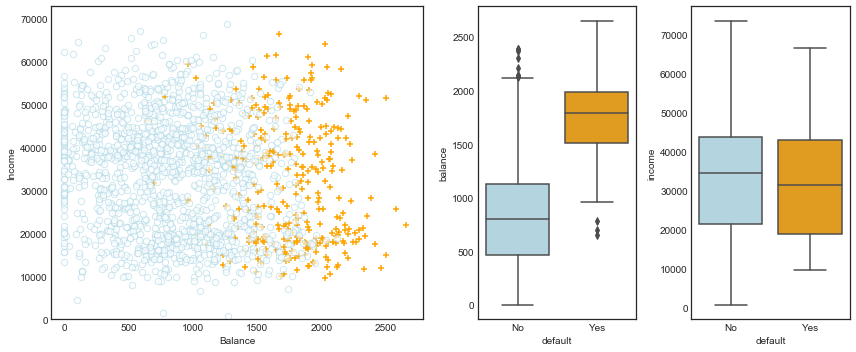

In [13]:
# a new figure
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
# we need three axisis
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default == 'No'].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default == 'Yes']
df_ = df_no.append(df_yes)
##### the left side plot
# plot blance (x-axis) and income (y-axis) all students with default=='Yes'
ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
# plot blance (x-axis) and income (y-axis) all students with default=='No'
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='white', alpha=.6)
# axis limits
ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')
##### the right side plot
# defining color plate
c_palette = {'No':'lightblue', 'Yes':'orange'}
# boxplot of balance for default==Yes and default==No
sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2, palette=c_palette)
# boxplot of Income for default==Yes and default==No
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3, palette=c_palette)
# scaling the plot
gs.tight_layout(plt.gcf())

#### Figure 4.1
The Default data set.
* **Left:** The annual incomes and monthly credit card balances of a number of individuals. The individuals who defaulted on their credit card payments are shown in orange, and those who did not are shown in blue.
* **Center:** Boxplots of balance as a function of default status.
* **Right:** Boxplots of income as a function of default status.

## 4.2 Why Not Linear Regression?

We have stated that linear regression is not appropriate in the case of a qualitative response. Why not? Suppose that we are trying to predict the medical condition of a patient in the emergency room on the basis of her symptoms. In this simplified
example, there are three possible diagnoses: ***stroke*** , ***drug overdose*** , and ***epileptic seizure***. We could consider encoding these values as a quantitative response variable, $Y$, as follows:

$$Y =
\begin{cases}
  1, & \mbox{if stroke;} \\
  2, & \mbox{if drug overdose ;}\\
  3, & \mbox{if epileptic seizure.}
\end{cases}$$


Using this coding, least squares could be used to fit a linear regressionmodel to predict $Y$ on the basis of a set of predictors $X_1 ,\ldots,X_p$ . ***Unfortunately, this coding implies an ordering on the outcomes, putting drug overdose in
between stroke and epileptic seizure***, and insisting that the difference between stroke and drug overdose is the same as the difference between drug overdose and epileptic seizure. In practice there is no particular reason that this needs to be the case. For instance, one could choose an equally reasonable coding,

$$Y =
\begin{cases}
  1, & \mbox{if epileptic seizure;} \\
  2, & \mbox{if stroke ;}\\
  3, & \mbox{if drug overdose.}
\end{cases}$$


For a binary (two level) qualitative response, the situation is better. For binary instance, perhaps there are only two possibilities for the patient’s medical condition: stroke and drug overdose . We could then potentially use the dummy variable approach from Section 3.3.1 to code the response as follows:

$$Y =
\begin{cases}
  0, & \mbox{if stroke ;}\\
  1, & \mbox{if drug overdose.}
\end{cases}$$

## 4.3 Logistic Regression


Consider again the Default data set, where the response default falls into one of two categories, ***Yes*** or ***No***. Rather than modeling this response $Y$ directly, logistic regression models the probability that $Y$ belongs to a particular category.

For the Default data, logistic regression models the probability of default. For example, the probability of default given balance can be written as 
$$Pr\text{( default = Yes | balance )}.$$
The values of $Pr\text{( default = Yes | balance )}$, which we abbreviate $p( balance )$, will range between 0 and 1. Then for any given value of balance, a prediction can be made for default . For example, one might predict **default = Yes** for any individual for whom $p(balance) > 0.5$. Alternatively, if a company wishes to be conservative in predicting individuals who are at risk for default, then they may choose to use a lower threshold, such as $p(balance) > 0.1$.

### 4.3.1 The Logistic Model

How should we model the relationship between $p(X) = Pr(Y = 1|X)$ and $X$? (For convenience we are using the generic 0/1 coding for the response). In [Section 4.2](#4.2-Why-Not-Linear-Regression?) we talked of using a linear regression model to represent these robabilities:
$$p(X) = \beta_0 + \beta_1 X.\quad (4.1)$$

If we use this approach to predict **default = Yes** using balance , then we obtain the model shown in the left-hand panel of [Figure 4.2](#Figure-4.2) Here we see the problem with this approach: for balances close to zero we predict a negative probability of default; if we were to predict for very large balances, we would get values bigger than 1. These predictions are not sensible, since of course the true probability of default, regardless of credit card balance, must fall between 0 and 1. This problem is not unique to the credit default data. Any time a straight line is fit to a binary response that is coded as 0 or 1, in principle we can always predict $p(X) < 0$ for some values of $X$ and $p(X) > 1$ for others (unless the range of $X$ is limited).

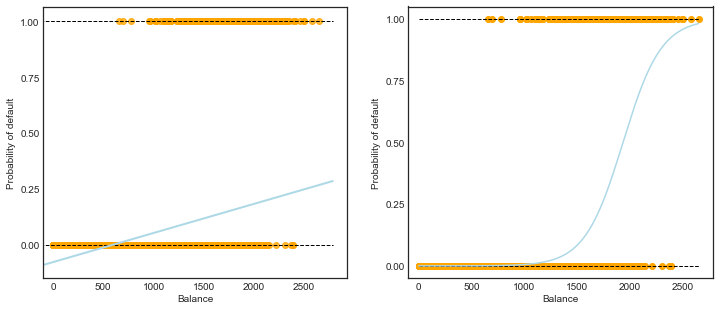

In [15]:
# X_train data
X_train = df.balance.values.reshape(-1,1) 
y = df.default2

# Create array of test data. Calculate the classification probability
# and predicted classification.
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)
# using logestinc regression with netwon cg algorithm 
clf = skl_lm.LogisticRegression(solver='newton-cg')
# fitting the train data
clf.fit(X_train,y)
# the probability of X_test data
prob = clf.predict_proba(X_test)
# a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot
## regular regression
sns.regplot(df.balance, df.default2, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

#### Figure 4.2
Classification using the Default data.
* **Left:** Estimated probability of default using linear regression. Some estimated probabilities are negative!
The orange ticks indicate the 0/1 values coded for default(No or Yes).
* **Right:**
Predicted probabilities of default using logistic regression. All probabilities lie between 0 and 1.

To avoid this problem, we must model $p(X)$ using a function that gives outputs between 0 and 1 for all values of $X$. Many functions meet this description. In logistic regression, we use the logistic function, logistic function
$$p(X) = \frac{\exp (\beta_0 +\beta_1 X)}{1 + \exp (\beta_0 +\beta_1 X)} \quad . (4.2)$$

To fit the model (4.2), we use a method called maximum likelihood, which maximum likelihood we discuss in the next section. The right-hand panel of [Figure 4.2](#Figure-4.2) illustrates the fit of the logistic regression model to the Default data. Notice that for low balances we now predict the probability of default as close to, but never below, zero. Likewise, for high balances we predict a default probability close to, but never above, one. The logistic function will always produce an **S-shaped** curve of this form, and so regardless of the value of $X$, we will obtain a sensible prediction. We also see that the logistic model is better able to capture the range of probabilities than is the linear regression model in the left-hand plot. The average fitted probability in both cases is 0.0333 (averaged over the training data), which is the same as the overall proportion of defaulters in the data set. 

After a bit of manipulation of (4.2), we find that
$$\frac{p(X)}{1 − p(X)}= \exp(\beta_0 +\beta_1 X). \quad(4.3)$$
The quantity $p(X)/[1−p(X)]$ is called **the odds**, and can take on any value odds between 0 and $\inf$. Values of the odds close to 0 and $\inf$ indicate very low and very high probabilities of default, respectively. For example, on average 1 in 5 people with an odds of 1/4 will default, since $p(X) = 0.2$ implies an odds of
$\frac{0.2}{1−0.2 } = 1/4$. Likewise on average nine out of every ten people with an odds of 9 will default, since $p(X) = 0.9$ implies an odds of
$\frac{0.9}{1−0.9}= 9.$ Odds are traditionally used instead of probabilities in horse-racing, since they relate more naturally to the correct betting strategy. 

By taking the logarithm of both sides of (4.3), we arrive at
$$\log\left(\frac{p(X)}{1 − p(X)}\right)= \beta_0 + \beta_1 X.\quad (4.4)$$
The left-hand side is called the **log-odds** or **logit**. We see that the logistic regression model (4.2) has a logit that is linear in $X$. 

### 4.3.2 Estimating the Regression Coefficients

### Table 4.1
For the Default data, estimated coefficients of the logistic regression model that predicts the probability of default using balance. A one-unit increase in balance is associated with an increase in the log odds of default by 0.0055 units.

In [16]:
y = df.default2
# Using newton-cg solver, the coefficients are equal/closest to the ones in the book. 
# I do not know the details on the differences between the solvers.
clf = skl_lm.LogisticRegression(solver='newton-cg')
X_train = df.balance.values.reshape(-1,1)
clf.fit(X_train,y)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
classes:  [0 1]
coefficients:  [[0.00549892]]
intercept : [-10.65133001]


##### statsmodels

In [17]:
formula = 'default ~ balance'
model = smf.glm(formula = formula, data=df, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                        Generalized Linear Model Regression Results                        
Dep. Variable:     ['default[No]', 'default[Yes]']   No. Observations:                10000
Model:                                         GLM   Df Residuals:                     9998
Model Family:                             Binomial   Df Model:                            1
Link Function:                               logit   Scale:                          1.0000
Method:                                       IRLS   Log-Likelihood:                -798.23
Date:                             Mon, 30 Sep 2019   Deviance:                       1596.5
Time:                                     15:37:54   Pearson chi2:                 7.15e+03
No. Iterations:                                  9                                         
Covariance Type:                         nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-

In [18]:
result.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,10.6513,0.361,29.491,0.000,9.943,11.359
balance,-0.0055,0.000,-24.952,0.000,-0.006,-0.005


Many aspects of the logistic regression output shown in [Table 4.1](#Table-4.1) are similar to the linear regression output of Chapter 3. For example, we can measure the accuracy of the coefficient estimates by computing their standard errors. The z-statistic in [Table 4.1](#Table-4.1) plays the same role as the t-statistic in the linear regression output, for example in Table 3.1 on page 68. For instance, the z-statistic associated with $\beta_1$ is equal to $\hat{\beta}_1 /SE(\hat{\beta}_1 )$, and so a large (absolute) value of the z-statistic indicates evidence against the null hypothesis $H 0 : \beta_1 = 0$. This null hypothesis implies that $p(X) =\frac{\beta_0}{1+\exp(\beta_0)}$ — in other words, that the probability of default does not depend on balance. Since the p-value associated with balance in Table 4.1 is tiny, we can reject $H_0$. In other words, we conclude that there is indeed an association between balance and probability of default . The estimated intercept in Table 4.1
is typically not of interest; its main purpose is to adjust the average fitted probabilities to the proportion of ones in the data.

### 4.3.3 Making Predictions


The logistic regression model that results from predicting probability of default from student status can be seen in [Table 4.2](#Table-4.2) The coefficient associated with the dummy variable is positive, and the associated p-value is statistically significant. This indicates that
students tend to have higher default probabilities than non-students. 

###  Table 4.2

In [19]:
formula = 'default ~ student'
model = smf.glm(formula = formula, data=df, family=sm.families.Binomial())
result = model.fit()
result.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,3.5041,0.071,49.554,0.000,3.366,3.643
student[T.Yes],-0.4049,0.115,-3.520,0.000,-0.630,-0.179


# Logistic Regression

We now consider the problem of predicting a binary response using multiple predictors. By analogy with the extension from simple to multiple linear regression in Chapter 3, we can generalize (4.4) as follows:
$$\log\left(\frac{p(X)}{1 - p(X)}\right)= \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p,\qquad (4.6)$$
where $X= (X_1 ,...,X_p )$ are $p$ predictors. Equation 4.6 can be rewritten as
$$p(X) =\frac{e^{\beta_0 +\beta_1 X_1 +\dots+\beta_p X_p}}{1 + e^{\beta_0 +\beta_1 X_1 +\dots+\beta_p X_p}}.\qquad (4.7)$$

Just as in Section 4.3.2, we use the maximum likelihood method to estimate $\beta_0$,~\beta_1,\dots,\beta_p$. 

###  Table 4.3 - Multiple Logistic Regression

In [10]:
formula = 'default ~ student + income + balance'
model = smf.glm(formula = formula, data=df, family=sm.families.Binomial())
result = model.fit()
result.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,10.8690,0.492,22.079,0.000,9.904,11.834
student[T.Yes],0.6468,0.236,2.738,0.006,0.184,1.110
income,-3.033e-06,8.2e-06,-0.370,0.712,-1.91e-05,1.3e-05
balance,-0.0057,0.000,-24.737,0.000,-0.006,-0.005


**TABLE 4.3.** For the Default data, estimated coefficients of the logistic regression model that predicts the probability of default using balance, income, and student status. Student status is encoded as a dummy variable student[Yes], with a value of 1 for a student and a value of 0 for a non-student. In fitting this model, income was measured in thousands of dollars.

### Figure 4.3 - Confounding

In [15]:
# balance and default vectors for students
X_train = df[df.student == 'Yes'].balance.values.reshape(df[df.student == 'Yes'].balance.size,1) 
y = df[df.student == 'Yes'].default2

# balance and default vectors for non-students
X_train2 = df[df.student == 'No'].balance.values.reshape(df[df.student == 'No'].balance.size,1) 
y2 = df[df.student == 'No'].default2

# Vector with balance values for plotting
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf2 = skl_lm.LogisticRegression(solver='newton-cg')

clf.fit(X_train,y)
clf2.fit(X_train2,y2)

prob = clf.predict_proba(X_test)
prob2 = clf2.predict_proba(X_test)

In [16]:
df.groupby(['student','default']).size().unstack('default')

default,No,Yes
student,,
No,6850,206
Yes,2817,127


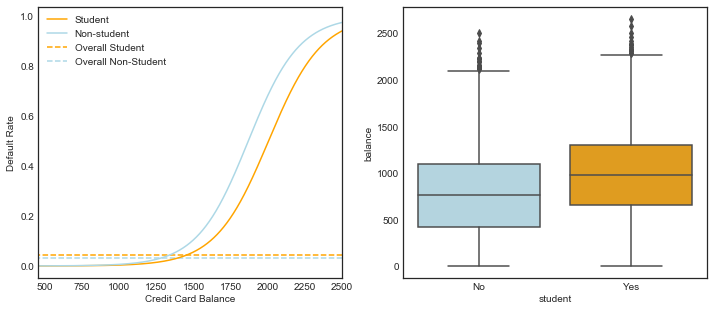

In [17]:
# creating plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.plot(X_test, pd.DataFrame(prob)[1], color='orange', label='Student')
ax1.plot(X_test, pd.DataFrame(prob2)[1], color='lightblue', label='Non-student')
ax1.hlines(127/2817, colors='orange', label='Overall Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.hlines(206/6850, colors='lightblue', label='Overall Non-Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450,2500)
ax1.legend(loc=2)

# Right plot
sns.boxplot('student', 'balance', data=df, orient='v', ax=ax2,  palette=c_palette);

The right-hand panel of Figure 4.3 provides an explanation for this discrepancy. The variables student and balance are correlated. Students tend
to hold higher levels of debt, which is in turn associated with higher probability of default. In other words, students are more likely to have large
credit card balances, which, as we know from the left-hand panel of Figure 4.3, tend to be associated with high default rates. Thus, even though
an individual student with a given credit card balance will tend to have a lower probability of default than a non-student with the same credit card
balance, the fact that students on the whole tend to have higher credit card balances means that overall, students tend to default at a higher rate than
non-students. This is an important distinction for a credit card company that is trying to determine to whom they should offer credit. A student is
riskier than a non-student if no information about the student’s credit card balance is available. However, that student is less risky than a non-student
with the same credit card balance!

This simple example illustrates the dangers and subtleties associated with performing regressions involving only a single predictor when other
predictors may also be relevant. As in the linear regression setting, the results obtained using one predictor may be quite different from those obtained using multiple predictors, especially when there is correlation among the predictors. In general, the phenomenon seen in Figure 4.3 is known as **confounding**. 

### 4.3.5 Logistic Regression for >2 Response Classes

We sometimes wish to classify a response variable that has more than two classes. For example, in Section 4.2 we had three categories of medical condition in the emergency room: ***stroke***, ***drug overdose***, ***epileptic seizure***.
In this setting, we wish to model both **Pr(Y = stroke |X)** and **Pr(Y = drug overdose |X)**, with the remaining **Pr(Y = epileptic seizure |X) =1 − Pr(Y = stroke |X) − Pr(Y = drug overdose |X)**. The two-class logistic regression models discussed in the previous sections have multiple-class extensions, but in practice they tend not to be used all that often. One of
the reasons is that the method we discuss in the next section, discriminant

## 4.4 Linear Discriminant Analysis
### Table 4.4 

A confusion matrix compares the LDA predictions to the true default statuses for the 10,000 training observations in the Default data set. Elements on the diagonal of the matrix represent individuals whose default statuses were correctly predicted, while off-diagonal elements represent individuals that were misclassified. LDA made incorrect predictions for 23 individuals who did not default and for 252 individuals who did default.

In [58]:
X = df[['balance', 'income', 'student2']].to_numpy()
y = df.default2.to_numpy()

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X, y).predict(X)

df_ = pd.DataFrame({'True default status': y, 'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9645,254
Yes,22,79


In [59]:
print(classification_report(y, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.97      1.00      0.99      9667
         Yes       0.78      0.24      0.36       333

    accuracy                           0.97     10000
   macro avg       0.88      0.62      0.67     10000
weighted avg       0.97      0.97      0.97     10000



### Table 4.5
Instead of using the probability of 50% as decision boundary, we say that a probability of default of 20% is to be classified as 'Yes'.

In [60]:
decision_prob = 0.2
y_prob = lda.fit(X, y).predict_proba(X)

df_ = pd.DataFrame({'True default status': y, 'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9435,140
Yes,232,193


#  Lab

### 4.6.3 Linear Discriminant Analysis

In [18]:
df = pd.read_csv('Data/Smarket.csv', usecols=range(1,10), index_col=0, parse_dates=True)

In [19]:
X_train = df[:'2004'][['Lag1','Lag2']]
y_train = df[:'2004']['Direction']

X_test = df['2005':][['Lag1','Lag2']]
y_test = df['2005':]['Direction']

lda = LinearDiscriminantAnalysis()
pred = lda.fit(X_train, y_train).predict(X_test)

In [20]:
lda.priors_

array([ 0.49198397,  0.50801603])

In [21]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [22]:
# These do not seem to correspond to the values from the R output in the book?
lda.coef_

array([[-0.05544078, -0.0443452 ]])

In [23]:
confusion_matrix(y_test, pred).T

array([[ 35,  35],
       [ 76, 106]])

In [24]:
print(classification_report(y_test, pred, digits=3))

             precision    recall  f1-score   support

       Down      0.500     0.315     0.387       111
         Up      0.582     0.752     0.656       141

avg / total      0.546     0.560     0.538       252



In [25]:
pred_p = lda.predict_proba(X_test)

In [26]:
np.unique(pred_p[:,1]>0.5, return_counts=True)

(array([False,  True], dtype=bool), array([ 70, 182]))

In [27]:
np.unique(pred_p[:,1]>0.9, return_counts=True)

(array([False], dtype=bool), array([252]))

### 4.6.4 Quadratic Discriminant Analysis

In [28]:
qda = QuadraticDiscriminantAnalysis()
pred = qda.fit(X_train, y_train).predict(X_test)

In [29]:
qda.priors_

array([ 0.49198397,  0.50801603])

In [30]:
qda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [31]:
confusion_matrix(y_test, pred).T

array([[ 30,  20],
       [ 81, 121]])

In [32]:
print(classification_report(y_test, pred, digits=3))

             precision    recall  f1-score   support

       Down      0.600     0.270     0.373       111
         Up      0.599     0.858     0.706       141

avg / total      0.599     0.599     0.559       252



### 4.6.5 K-Nearest Neighbors

In [33]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred).T)
print(classification_report(y_test, pred, digits=3))

[[43 58]
 [68 83]]
             precision    recall  f1-score   support

       Down      0.426     0.387     0.406       111
         Up      0.550     0.589     0.568       141

avg / total      0.495     0.500     0.497       252



In [34]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred).T)
print(classification_report(y_test, pred, digits=3))

[[48 55]
 [63 86]]
             precision    recall  f1-score   support

       Down      0.466     0.432     0.449       111
         Up      0.577     0.610     0.593       141

avg / total      0.528     0.532     0.529       252



### 4.6.6 An Application to Caravan Insurance Data

#### K-Nearest Neighbors

In [35]:
# In R, I exported the dataset from package 'ISLR' to a csv file
df = pd.read_csv('Data/Caravan.csv')
y = df.Purchase
X = df.drop('Purchase', axis=1).astype('float64')
X_scaled = preprocessing.scale(X)

X_train = X_scaled[1000:,:]
y_train = y[1000:]
X_test = X_scaled[:1000,:]
y_test = y[:1000]

def KNN(n_neighbors=1, weights='uniform'):
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    return(pred, score, clf.classes_)

def plot_confusion_matrix(cm, classes, n_neighbors, title='Confusion matrix (Normalized)',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized confusion matrix: KNN-{}'.format(n_neighbors))
    plt.colorbar()
    plt.xticks(np.arange(2), classes)
    plt.yticks(np.arange(2), classes)
    plt.tight_layout()
    plt.xlabel('True label',rotation='horizontal', ha='right')
    plt.ylabel('Predicted label')
    plt.show()

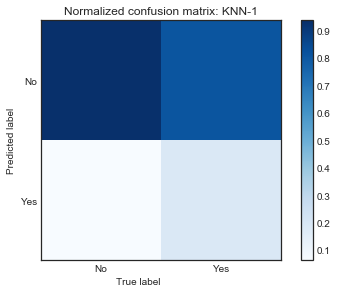

True        No  Yes
Predicted          
No         882   48
Yes         59   11
     Precision
No    0.948387
Yes   0.157143


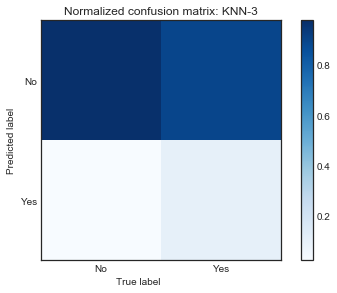

True        No  Yes
Predicted          
No         921   53
Yes         20    6
     Precision
No    0.945585
Yes   0.230769


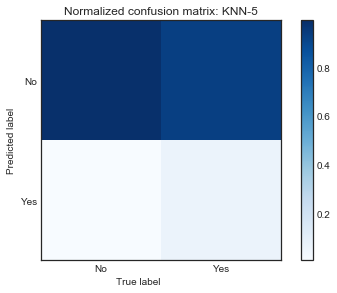

True        No  Yes
Predicted          
No         934   55
Yes          7    4
     Precision
No    0.944388
Yes   0.363636


In [36]:
for i in [1,3,5]:
    pred, score, classes = KNN(i)
    cm = confusion_matrix(y_test, pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized.T, classes, n_neighbors=i)
    cm_df = pd.DataFrame(cm.T, index=classes, columns=classes)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print(cm_df)    
    print(pd.DataFrame(precision_score(y_test, pred, average=None),
                       index=classes, columns=['Precision']))        

####  Logistic Regression

In [37]:
regr = skl_lm.LogisticRegression()
regr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
pred = regr.predict(X_test)
cm_df = pd.DataFrame(confusion_matrix(y_test, pred).T, index=regr.classes_,
                     columns=regr.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)
print(classification_report(y_test, pred))

True        No  Yes
Predicted          
No         935   59
Yes          6    0
             precision    recall  f1-score   support

         No       0.94      0.99      0.97       941
        Yes       0.00      0.00      0.00        59

avg / total       0.89      0.94      0.91      1000



In [39]:
pred_p = regr.predict_proba(X_test)
cm_df = pd.DataFrame({'True': y_test, 'Pred': pred_p[:,1] > .25})
cm_df.Pred.replace(to_replace={True:'Yes', False:'No'}, inplace=True)
print(cm_df.groupby(['True', 'Pred']).size().unstack('True').T)
print(classification_report(y_test, cm_df.Pred))

Pred   No  Yes
True          
No    919   22
Yes    48   11
             precision    recall  f1-score   support

         No       0.95      0.98      0.96       941
        Yes       0.33      0.19      0.24        59

avg / total       0.91      0.93      0.92      1000

